In [1]:
# importing all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

In [3]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)



100%|██████████| 9912422/9912422 [00:00<00:00, 111098463.07it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35091452.44it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24974059.20it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18993548.12it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [16]:
resnet50 = resnet34(NUM_CLASSES)
resnet50.to(DEVICE)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
resnet50.load_state_dict(torch.load('/kaggle/input/mnist_resnet50/pytorch/lol/1/Resnet50.pt'))
resnet50.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

In [24]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(resnet50, test_loader, device=DEVICE)))

Test accuracy: 99.14%


In [29]:
import torch
import numpy as np
import pandas as pd
import os

def load_csv_images(csv_file):
    df = pd.read_csv(csv_file)
    labels = df['Label'].values
    images = df.drop('Label', axis=1).values
    # Reshape the images to the expected shape [num_samples, num_channels, height, width]
    images = images.reshape(-1, 1, 28, 28)
    return images, labels

def compute_accuracy(model, test_loader, device):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            logits, probas = model(features.float())  # Ensure input is of the same data type as model weights
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item()
    return correct_pred / num_examples * 100

def evaluate_csv_files(resnet50, csv_files, device):
    for csv_file in csv_files:
        images, labels = load_csv_images(csv_file)
        dataset = torch.utils.data.TensorDataset(torch.tensor(images), torch.tensor(labels))
        loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
        accuracy = compute_accuracy(resnet50, loader, device)
        print(f'Accuracy for {csv_file}: {accuracy:.2f}%')

# Define the paths
csv_files_directory = "/kaggle/input/perturbed/"

# Get the list of CSV files in the directory
csv_files = [os.path.join(csv_files_directory, file) for file in os.listdir(csv_files_directory) if file.endswith(".csv")]


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate each CSV file
evaluate_csv_files(resnet50, csv_files, device)


Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_20.csv: 80.47%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.001.csv: 78.91%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_100.csv: 53.12%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.05.csv: 81.25%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_5.0.csv: 69.53%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.5.csv: 80.47%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.01.csv: 82.81%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_10.csv: 39.84%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.1.csv: 71.88%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_1.0.csv: 75.78%


Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_20.csv: 80.47%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.001.csv: 78.91%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_100.csv: 53.12%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.05.csv: 81.25%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_5.0.csv: 69.53%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.5.csv: 80.47%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.01.csv: 82.81%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_10.csv: 39.84%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.1.csv: 71.88%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_1.0.csv: 75.78%


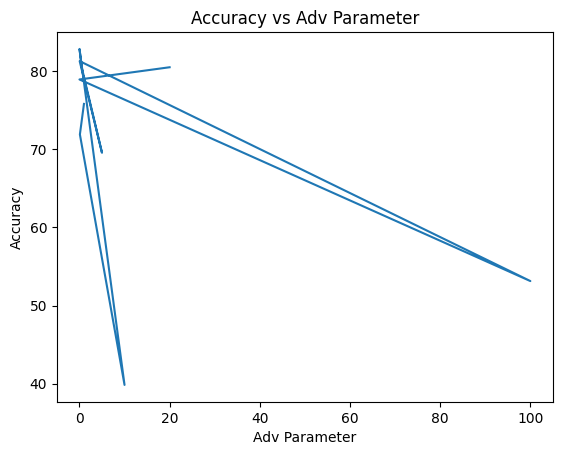

In [30]:
import torch
import numpy as np
import pandas as pd
import os

def load_csv_images(csv_file):
    df = pd.read_csv(csv_file)
    labels = df['Label'].values
    images = df.drop('Label', axis=1).values
    # Reshape the images to the expected shape [num_samples, num_channels, height, width]
    images = images.reshape(-1, 1, 28, 28)
    return images, labels

def compute_accuracy(model, test_loader, device):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            logits, probas = model(features.float())  # Ensure input is of the same data type as model weights
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item()
    return correct_pred / num_examples * 100

def evaluate_csv_files(resnet50, csv_files, device):
    accuracy_dict = {}
    for csv_file in csv_files:
        adv_parameter = float(os.path.splitext(os.path.basename(csv_file))[0].split('_')[-1])
        images, labels = load_csv_images(csv_file)
        dataset = torch.utils.data.TensorDataset(torch.tensor(images), torch.tensor(labels))
        loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
        accuracy = compute_accuracy(resnet50, loader, device)
        accuracy_dict[adv_parameter] = accuracy
        print(f'Accuracy for {csv_file}: {accuracy:.2f}%')
    return accuracy_dict
# Define the paths
csv_files_directory = "/kaggle/input/perturbed/"

# Get the list of CSV files in the directory
csv_files = [os.path.join(csv_files_directory, file) for file in os.listdir(csv_files_directory) if file.endswith(".csv")]


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate each CSV file
# Evaluate each CSV file
accuracy_dict = evaluate_csv_files(resnet50, csv_files, device)

# Plot the graph
adv_parameters = list(accuracy_dict.keys())
accuracies = list(accuracy_dict.values())

plt.plot(adv_parameters, accuracies)
plt.xlabel('Adv Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Adv Parameter')
plt.show()


In [31]:
accuracy_dict

{20.0: 80.46875,
 0.001: 78.90625,
 100.0: 53.125,
 0.05: 81.25,
 5.0: 69.53125,
 0.5: 80.46875,
 0.01: 82.8125,
 10.0: 39.84375,
 0.1: 71.875,
 1.0: 75.78125}

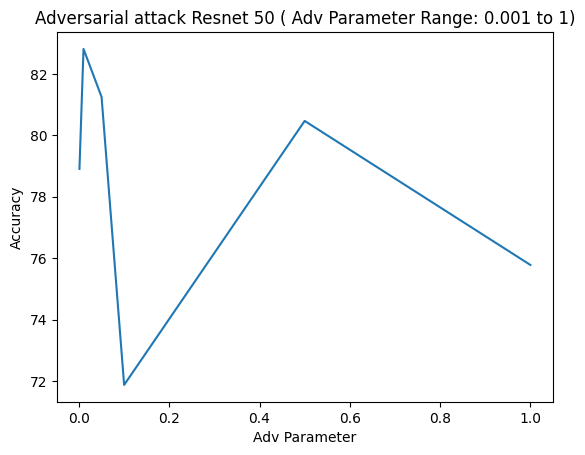

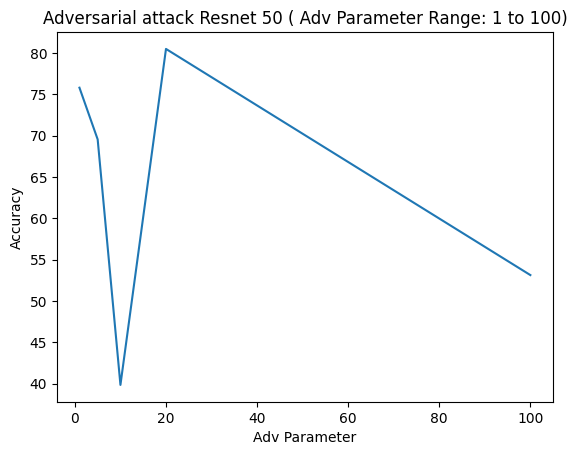

In [41]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracy_dict, start_range, end_range):
    adv_parameters = []
    accuracies = []
    sorted_accuracy_dict = sorted(accuracy_dict.items(), key=lambda x: x[0])
    for adv_param, accuracy in sorted_accuracy_dict:
        if start_range <= adv_param <= end_range:
            adv_parameters.append(adv_param)
            accuracies.append(accuracy)

    plt.plot(adv_parameters, accuracies)
    plt.xlabel('Adv Parameter')
    plt.ylabel('Accuracy')
    plt.title(f'Adversarial attack Resnet 50 ( Adv Parameter Range: {start_range} to {end_range})')
    plt.show()

accuracy_dict = {
    20.0: 80.46875,
    0.001: 78.90625,
    100.0: 53.125,
    0.05: 81.25,
    5.0: 69.53125,
    0.5: 80.46875,
    0.01: 82.8125,
    10.0: 39.84375,
    0.1: 71.875,
    1.0: 75.78125,
    
}

# Plot the first range from 0.001 to 1
plot_accuracy(accuracy_dict, 0.001, 1)

# Plot the second range from 1 to 100
plot_accuracy(accuracy_dict, 1, 100)


> **ATTACK ON RESNET 9**


In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, last_lr: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['lrs'][-1]))


def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [5]:
Resnet9 = ResNet9(1, 10)
Resnet9.to(DEVICE)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [6]:
Resnet9.load_state_dict(torch.load('/kaggle/input/mnist_resnet50/pytorch/lol/1/resnet.pt'))
Resnet9.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [8]:
import torch
import numpy as np
import pandas as pd
import os
import torch.nn.functional as F

# Function to load CSV images
def load_csv_images(csv_file):
    df = pd.read_csv(csv_file)
    labels = df['Label'].values
    images = df.drop('Label', axis=1).values
    # Reshape the images to the expected shape [num_samples, num_channels, height, width]
    images = images.reshape(-1, 1, 28, 28)
    return images, labels

# Function to compute accuracy
def compute_accuracy(model, test_loader, device):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features.float())  # Ensure input is of the same data type as model weights
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item()
    return correct_pred / num_examples * 100

# Function to evaluate CSV files
# Function to evaluate CSV files and return a dictionary of adv parameters and accuracies
def evaluate_csv_files(model, csv_files, device):
    adv_parameter_accuracies = {}
    for csv_file in csv_files:
        adv_parameter = float(os.path.splitext(os.path.basename(csv_file))[0].split('_')[-1])  # Extract adv parameter from file name
        images, labels = load_csv_images(csv_file)
        dataset = torch.utils.data.TensorDataset(torch.tensor(images), torch.tensor(labels))
        loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
        accuracy = compute_accuracy(model, loader, device)
        adv_parameter_accuracies[adv_parameter] = accuracy
        print(f'Accuracy for {csv_file}: {accuracy:.2f}%')
    return adv_parameter_accuracies




# Define the paths
csv_files_directory = "/kaggle/input/perturbed/"
csv_files = [os.path.join(csv_files_directory, file) for file in os.listdir(csv_files_directory) if file.endswith(".csv")]

# Define the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate CSV files using ResNet9 model
# Evaluate CSV files using ResNet9 model and store adv parameters along with accuracies
adv_parameter_accuracies = evaluate_csv_files(Resnet9, csv_files, device=DEVICE)


Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_20.csv: 21.88%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.001.csv: 21.09%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_100.csv: 17.97%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.05.csv: 22.66%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_5.0.csv: 20.31%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.5.csv: 21.09%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.01.csv: 21.09%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_10.csv: 18.75%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_0.1.csv: 19.53%
Accuracy for /kaggle/input/perturbed/reconstructed_images_adv_1.0.csv: 23.44%


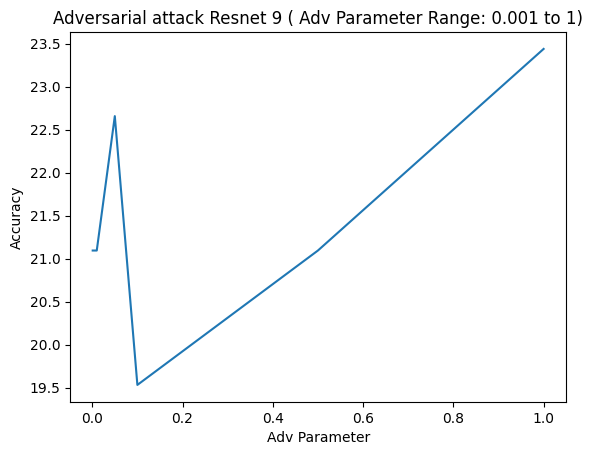

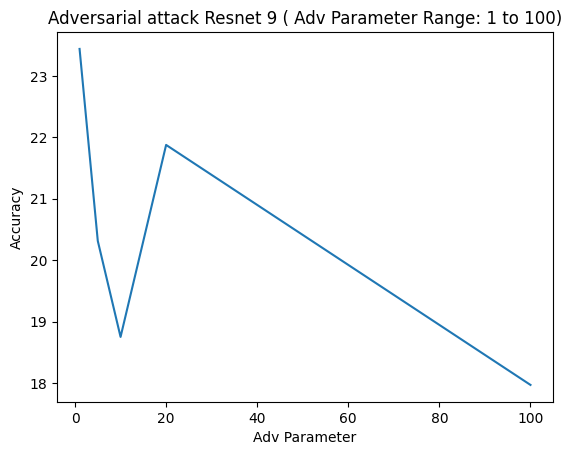

In [9]:
import matplotlib.pyplot as plt

def plot_accuracy_resnet9(accuracy_dict, start_range, end_range):
    adv_parameters = []
    accuracies = []
    sorted_accuracy_dict = sorted(accuracy_dict.items(), key=lambda x: x[0])
    for adv_param, accuracy in sorted_accuracy_dict:
        if start_range <= adv_param <= end_range:
            adv_parameters.append(adv_param)
            accuracies.append(accuracy)

    plt.plot(adv_parameters, accuracies)
    plt.xlabel('Adv Parameter')
    plt.ylabel('Accuracy')
    plt.title(f'Adversarial attack Resnet 9 ( Adv Parameter Range: {start_range} to {end_range})')
    plt.show()



# Plot the first range from 0.001 to 1
plot_accuracy_resnet9(adv_parameter_accuracies, 0.001, 1)

# Plot the second range from 1 to 100
plot_accuracy_resnet9(adv_parameter_accuracies, 1, 100)


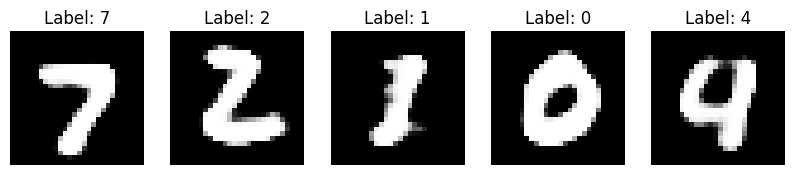

In [13]:
import matplotlib.pyplot as plt

# Function to load images and labels from a CSV file
def load_images_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    labels = df['Label'].values
    images = df.drop('Label', axis=1).values
    # Reshape the images to the expected shape [num_samples, num_channels, height, width]
    images = images.reshape(-1, 28, 28)  # Remove the channel dimension
    return images, labels

# Load images and labels from the CSV file corresponding to adv parameter 10
adv_10_csv_file = "/kaggle/input/perturbed/reconstructed_images_adv_20.csv"
images_10, labels_10 = load_images_from_csv(adv_10_csv_file)

# Plot 5 images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_10[i], cmap='gray')
    plt.title(f"Label: {labels_10[i]}")
    plt.axis('off')
plt.show()


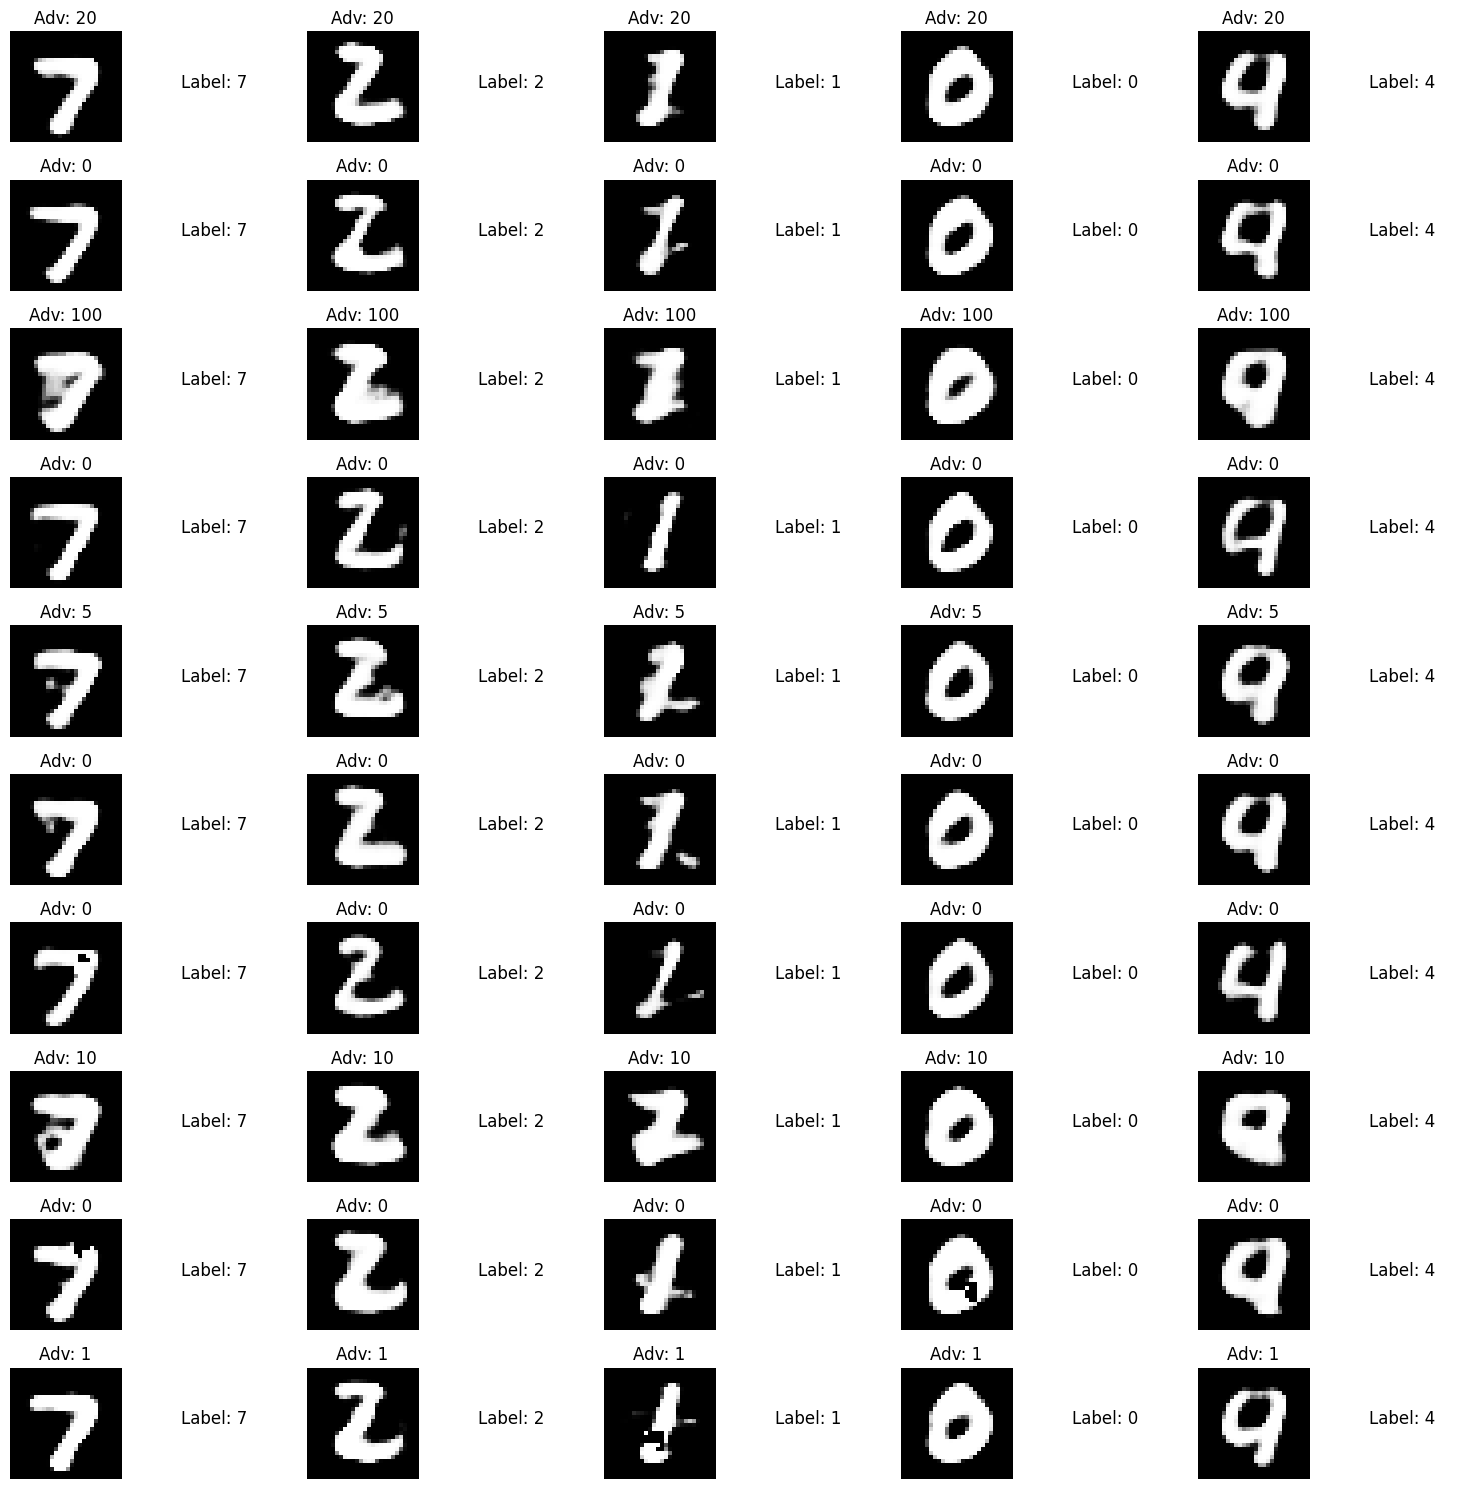

In [55]:
import matplotlib.pyplot as plt

# Function to load images and labels from a CSV file
def load_images_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    labels = df['Label'].values
    images = df.drop('Label', axis=1).values
    # Reshape the images to the expected shape [num_samples, num_channels, height, width]
    images = images.reshape(-1, 28, 28)  # Remove the channel dimension
    return images, labels

# Define the directory containing the CSV files
csv_files_directory = "/kaggle/input/perturbed/"

# Get the list of CSV files in the directory
csv_files = [os.path.join(csv_files_directory, file) for file in os.listdir(csv_files_directory) if file.endswith(".csv")]

# Plot images and labels for each adv_parameter
plt.figure(figsize=(15, 15))
num_images_per_row = 5
for i, csv_file in enumerate(csv_files, 1):
    images, labels = load_images_from_csv(csv_file)
    num_images = min(len(images), num_images_per_row)
    for j in range(num_images):
        plt.subplot(len(csv_files), num_images_per_row * 2, (i-1)*num_images_per_row*2 + j*2 + 1)
        plt.imshow(images[j], cmap='gray')
        plt.title(f"Adv: {os.path.basename(csv_file).split('_')[-1].split('.')[0]}")
        plt.axis('off')
        
        plt.subplot(len(csv_files), num_images_per_row * 2, (i-1)*num_images_per_row*2 + j*2 + 2)
        plt.text(0.5, 0.5, f"Label: {labels[j]}", fontsize=12, ha='center')
        plt.axis('off')
plt.tight_layout()
plt.show()


In [1]:
import matplotlib.pyplot as plt

# Function to load images and labels from a CSV file
def load_images_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    labels = df['Label'].values
    images = df.drop('Label', axis=1).values
    # Reshape the images to the expected shape [num_samples, num_channels, height, width]
    images = images.reshape(-1, 28, 28)  # Remove the channel dimension
    return images, labels

# Define the directory containing the CSV files
csv_files_directory = "/kaggle/input/perturbed/"

# Get the list of CSV files in the directory
csv_files = [os.path.join(csv_files_directory, file) for file in os.listdir(csv_files_directory) if file.endswith(".csv")]

# Plot images and labels for each adv_parameter
plt.figure(figsize=(15, 15))
num_images_per_row = 5
for i, csv_file in enumerate(csv_files, 1):
    images, labels = load_images_from_csv(csv_file)
    num_images = min(len(images), num_images_per_row)
    for j in range(num_images):
        plt.subplot(len(csv_files), num_images_per_row * 2, (i-1)*num_images_per_row*2 + j*2 + 1)
        plt.imshow(images[j], cmap='gray')
        plt.title(f"Adv: {os.path.basename(csv_file).split('_')[-1].split('.')[0]}")
        plt.axis('off')
        
        plt.subplot(len(csv_files), num_images_per_row * 2, (i-1)*num_images_per_row*2 + j*2 + 2)
        plt.text(0.5, 0.5, f"Label: {labels[j]}", fontsize=12, ha='center')
        plt.axis('off')
plt.tight_layout()
plt.show()


NameError: name 'os' is not defined

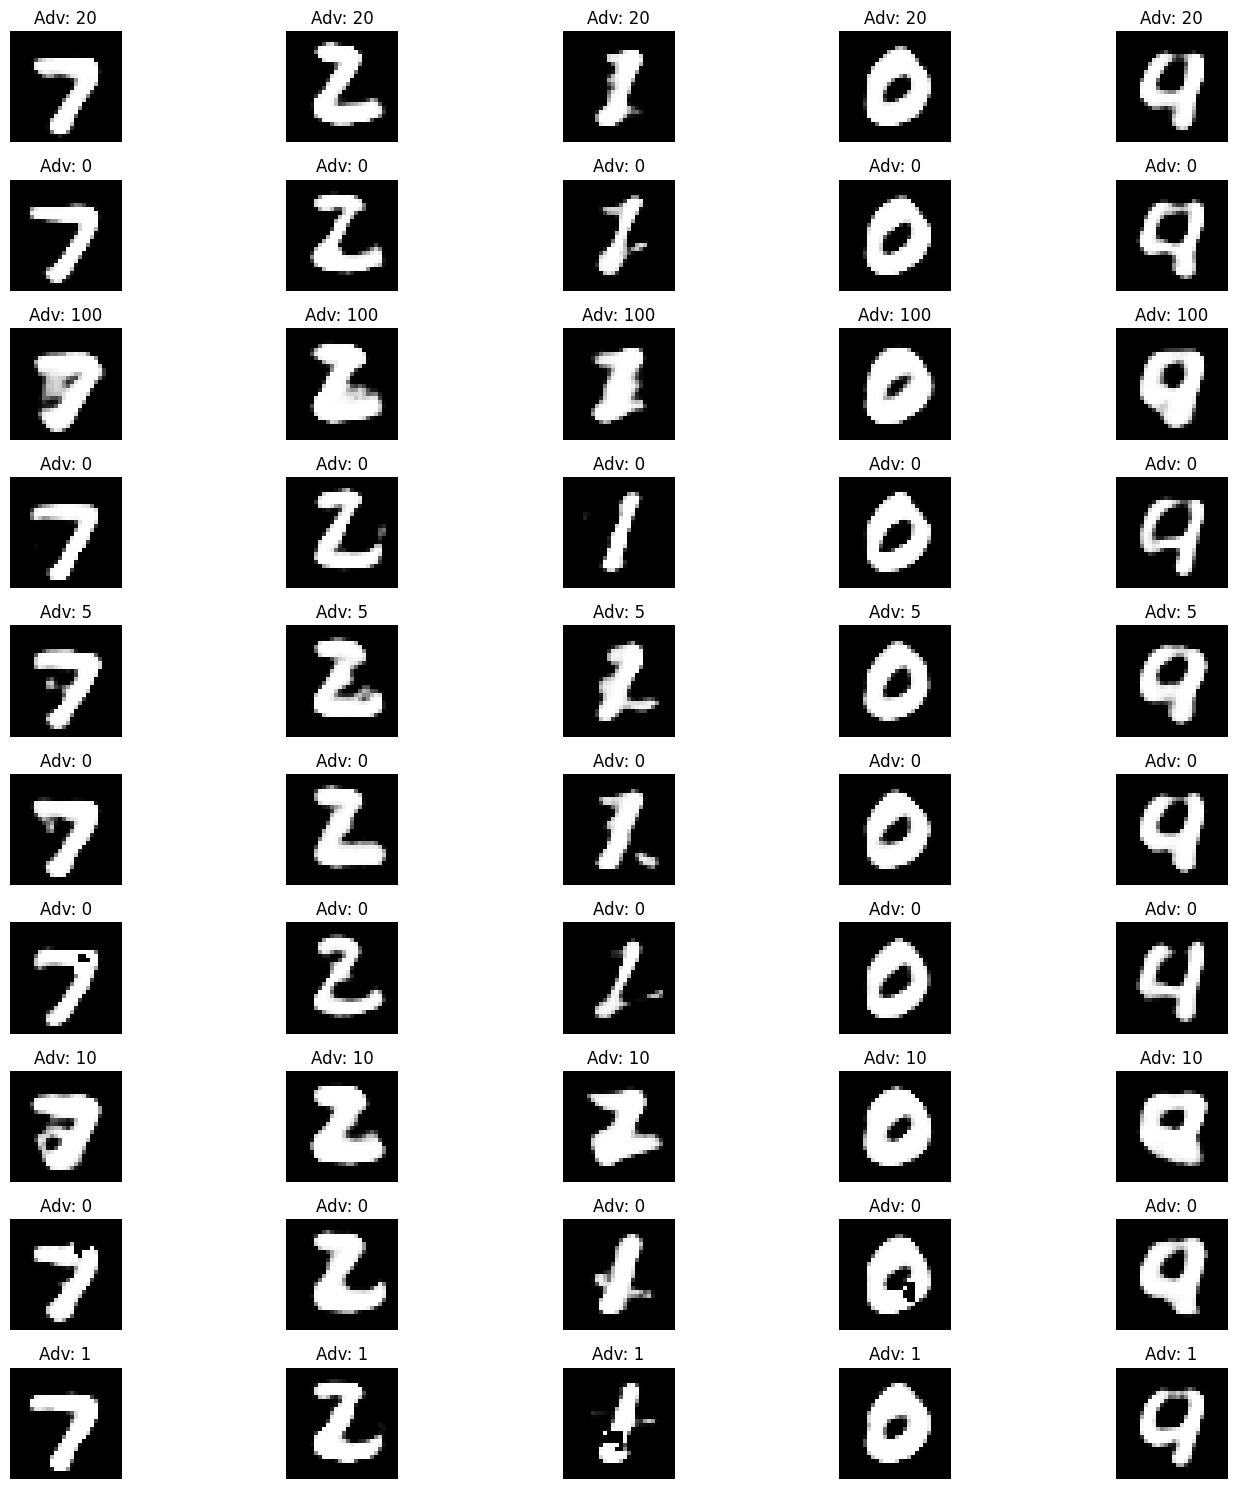

In [14]:
import matplotlib.pyplot as plt

# Function to load images from a CSV file
def load_images_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    images = df.drop('Label', axis=1).values
    # Reshape the images to the expected shape [num_samples, num_channels, height, width]
    images = images.reshape(-1, 28, 28)  # Remove the channel dimension
    return images

# Define the directory containing the CSV files
csv_files_directory = "/kaggle/input/perturbed/"

# Get the list of CSV files in the directory
csv_files = [os.path.join(csv_files_directory, file) for file in os.listdir(csv_files_directory) if file.endswith(".csv")]

# Plot images for each adv_parameter
plt.figure(figsize=(15, 15))
num_images_per_row = 5
for i, csv_file in enumerate(csv_files, 1):
    images = load_images_from_csv(csv_file)
    num_images = min(len(images), num_images_per_row)
    for j in range(num_images):
        plt.subplot(len(csv_files), num_images_per_row, (i-1)*num_images_per_row + j + 1)
        plt.imshow(images[j], cmap='gray')
        plt.title(f"Adv: {os.path.basename(csv_file).split('_')[-1].split('.')[0]}", fontsize=12)
        plt.axis('off')
plt.tight_layout()
plt.show()


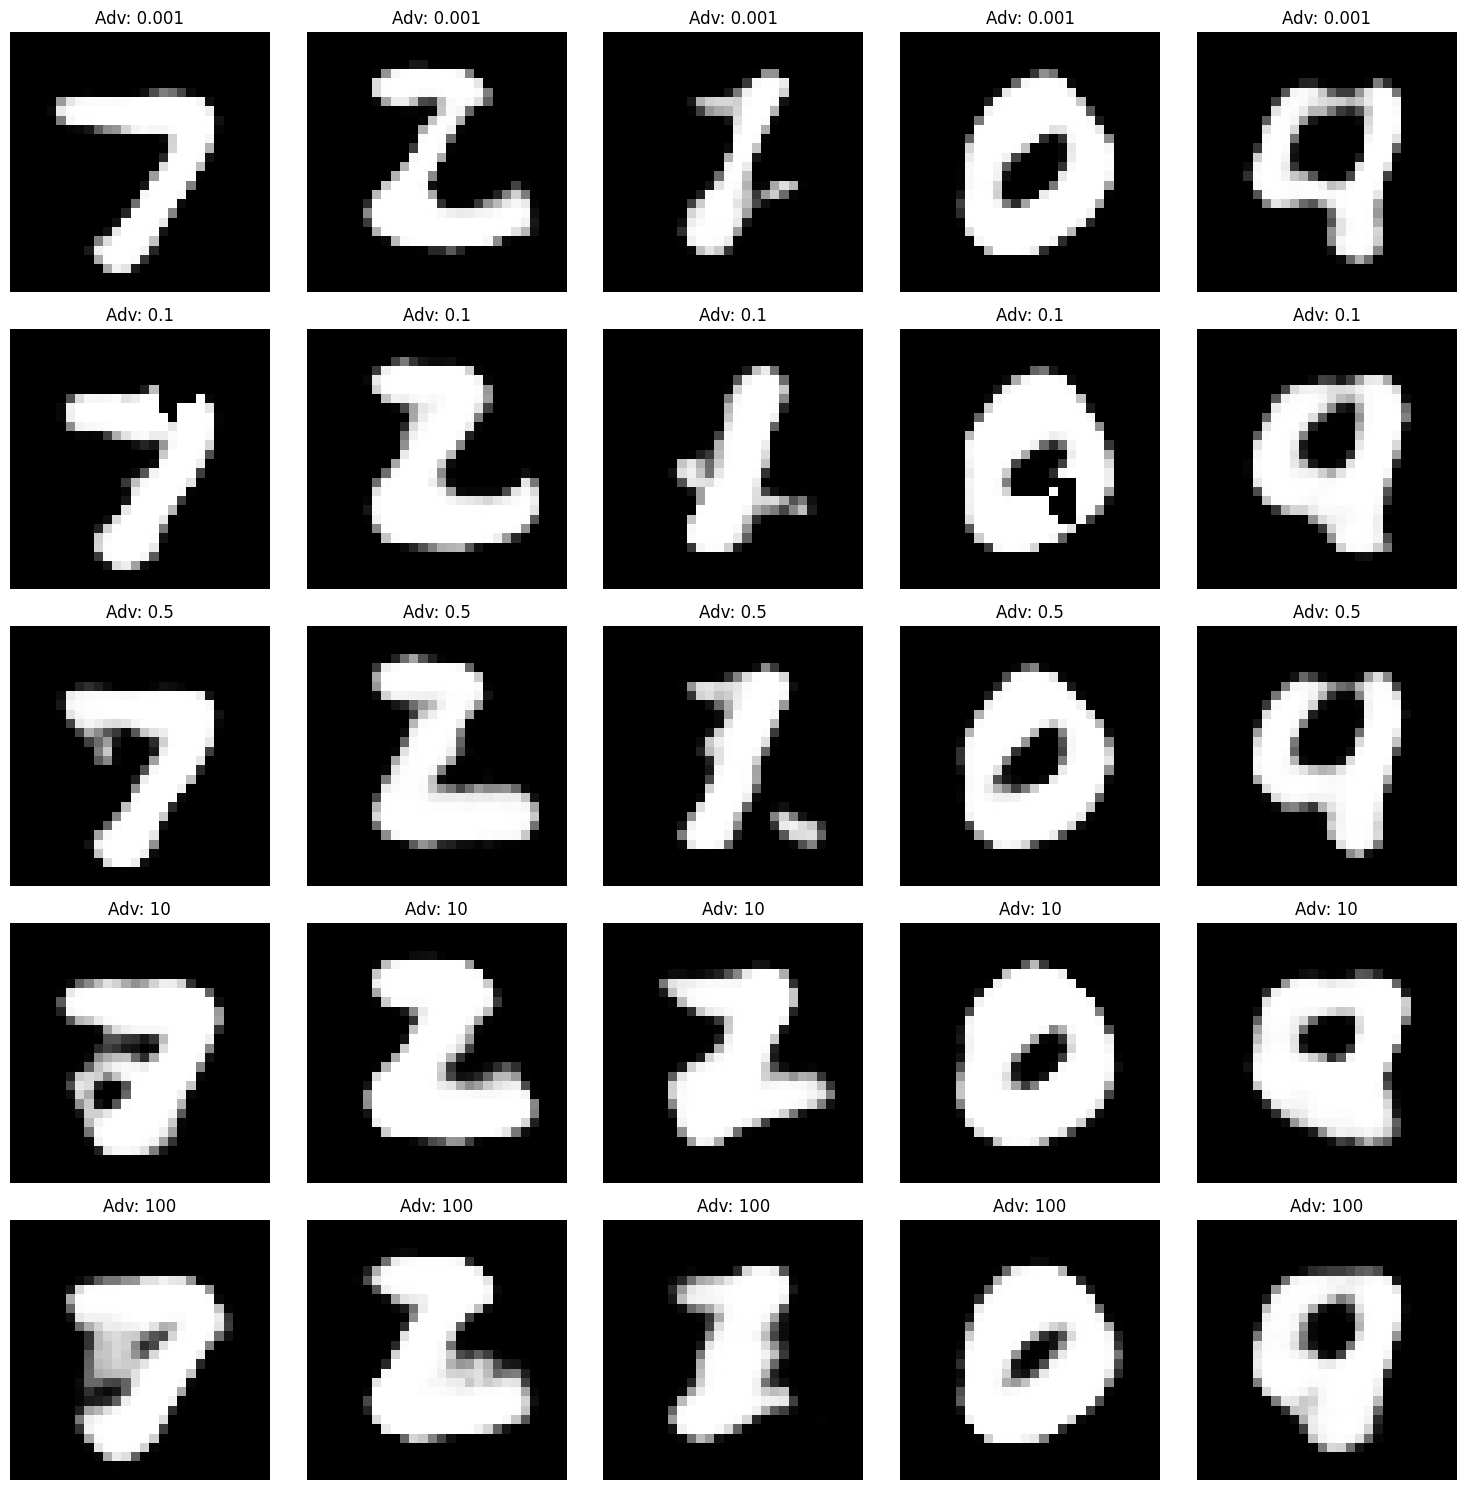

In [15]:
import matplotlib.pyplot as plt

# Define the adv_parameters to be plotted
adv_parameters_to_plot = [0.001, 0.1, 0.5, 10, 100]

# Plot images for each adv_parameter
plt.figure(figsize=(15, 15))
num_images_per_row = 5
for i, adv_parameter in enumerate(adv_parameters_to_plot, 1):
    csv_file = f"/kaggle/input/perturbed/reconstructed_images_adv_{adv_parameter}.csv"
    images = load_images_from_csv(csv_file)
    num_images = min(len(images), num_images_per_row)
    for j in range(num_images):
        plt.subplot(len(adv_parameters_to_plot), num_images_per_row, (i-1)*num_images_per_row + j + 1)
        plt.imshow(images[j], cmap='gray')
        plt.title(f"Adv: {adv_parameter}", fontsize=12)
        plt.axis('off')
plt.tight_layout()
plt.show()


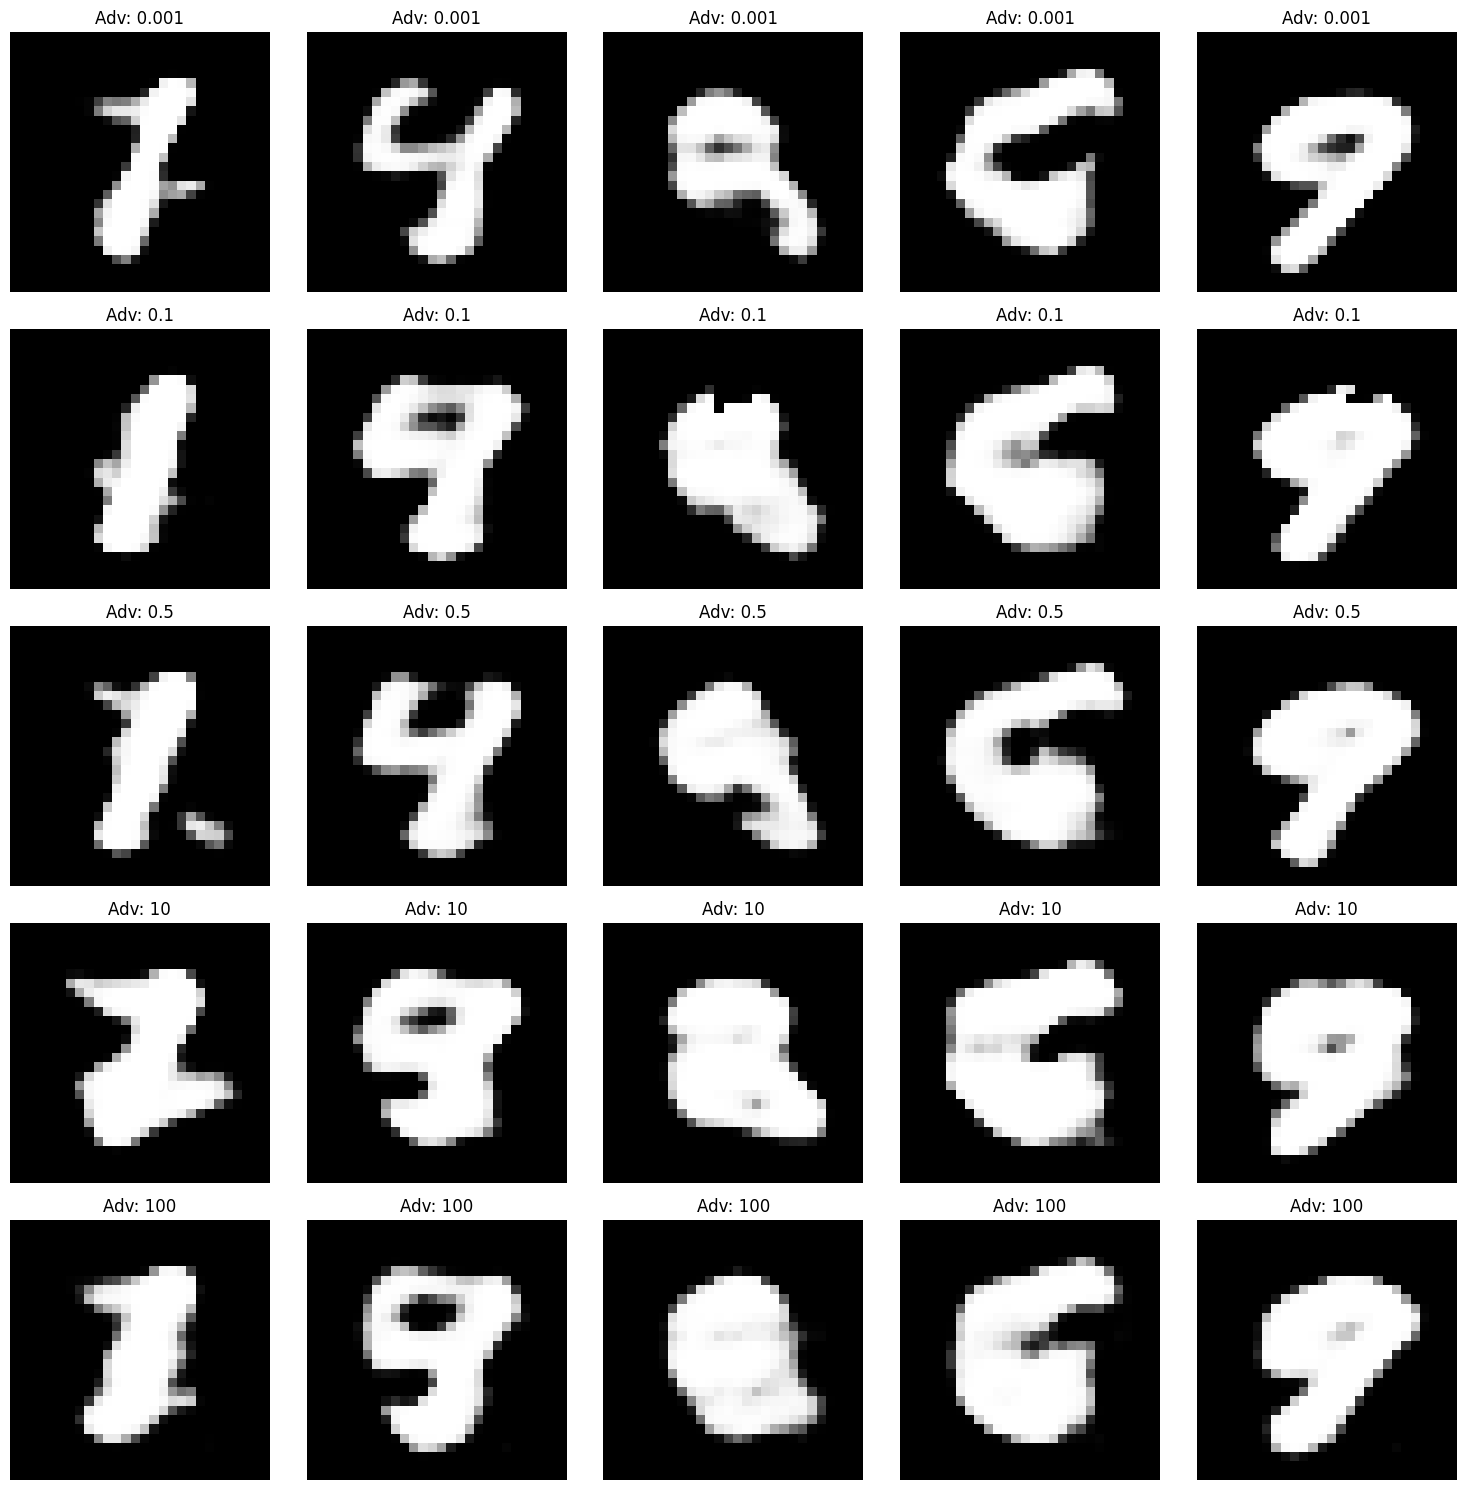

In [16]:
import matplotlib.pyplot as plt

# Define the adv_parameters to be plotted
adv_parameters_to_plot = [0.001, 0.1, 0.5, 10, 100]

# Plot images for each adv_parameter
plt.figure(figsize=(15, 15))
num_images_per_row = 5
num_skip_images = 5
for i, adv_parameter in enumerate(adv_parameters_to_plot, 1):
    csv_file = f"/kaggle/input/perturbed/reconstructed_images_adv_{adv_parameter}.csv"
    images = load_images_from_csv(csv_file)
    num_images = min(len(images), num_skip_images + num_images_per_row)
    for j in range(num_skip_images, num_images):
        plt.subplot(len(adv_parameters_to_plot), num_images_per_row, (i-1)*num_images_per_row + (j - num_skip_images) + 1)
        plt.imshow(images[j], cmap='gray')
        plt.title(f"Adv: {adv_parameter}", fontsize=12)
        plt.axis('off')
plt.tight_layout()
plt.show()


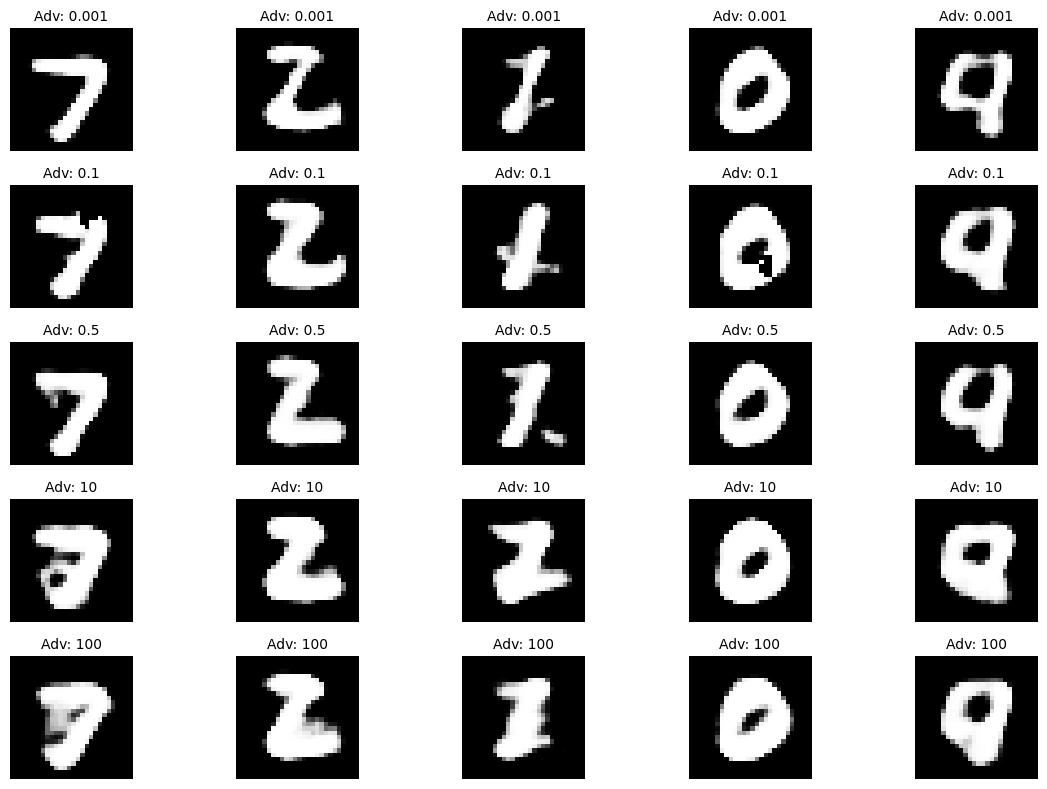

In [17]:
import matplotlib.pyplot as plt

# Define the adv_parameters to be plotted
adv_parameters_to_plot = [0.001, 0.1, 0.5, 10, 100]

# Plot images for each adv_parameter
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
num_images_per_row = 5
for i, adv_parameter in enumerate(adv_parameters_to_plot, 1):
    csv_file = f"/kaggle/input/perturbed/reconstructed_images_adv_{adv_parameter}.csv"
    images = load_images_from_csv(csv_file)
    num_images = min(len(images), num_images_per_row)
    for j in range(num_images):
        plt.subplot(len(adv_parameters_to_plot), num_images_per_row, (i-1)*num_images_per_row + j + 1)
        plt.imshow(images[j], cmap='gray')
        plt.title(f"Adv: {adv_parameter}", fontsize=10)  # Reduce font size
        plt.axis('off')
plt.tight_layout()
plt.show()
